In [ ]:
%load_ext autoreload
%autoreload 2

import os
import re

import numpy as np
import torch

from rl4co.envs import EVRPTWEnv 
from milp import batch_milp, check_actions_with_mask


In [2]:
def enforce_reproducibility(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [ ]:
results = []

# [num_loc, num_station, num_ev]
settings = [[10, 3, 3], [20, 3, 3], [50, 6, 6], [100, 12,12]]
solver_timelimit = 60
batch_size = 100

for num_loc, num_station, num_ev in settings:
    enforce_reproducibility(0)
    env = EVRPTWEnv(generator_params={'num_loc': num_loc, 
                                        'num_station': num_station,
                                        'vehicle_limit': num_ev,
                                        'vehicle_speed': 5,
                                        'vehicle_capacity': 1.5,
                                        'max_time': 1,
                                        'horizon': 1,
                                        'fuel_consumption_rate': 0.25,
                                        'inverse_recharge_rate': 0.25})
    td_init = env.reset(batch_size=[batch_size]).to('cuda')
    result = batch_milp(td_init, env, num_loc, num_station, num_ev, timelimit=solver_timelimit)

    results.append(result)

In [5]:
for r in results:
    print(f"C{r[0]:02d}-S{r[1]}-EV{r[2]} FeasibleCounts: {r[3]} AvgCost: {r[4]:.3f} AvgTime: {r[5]:.3f}")

C10-S3-EV3 FeasibleCounts: 100 AvgCost: 3.846 AvgTime: 35.357
C20-S3-EV3 FeasibleCounts: 100 AvgCost: 5.570 AvgTime: 58.901
C50-S6-EV6 FeasibleCounts: 100 AvgCost: 11.302 AvgTime: 60.128
C100-S12-EV12 FeasibleCounts: 79 AvgCost: 21.267 AvgTime: 60.138


# For Action Testing

In [ ]:
# indicate a save filename in a folder save_milp related to this notebook
filename = "actions_c020_s3_v3_b100.pt"

In [ ]:
num_loc, num_station, num_ev, batch_size  = [int(num) for num in re.findall(r'\d+', filename)]
actions = torch.load(os.path.join("save_milp", filename))
enforce_reproducibility(0)
env = EVRPTWEnv(generator_params={'num_loc': num_loc, 
                                    'num_station': num_station,
                                    'vehicle_limit': num_ev,
                                    'vehicle_speed': 5,
                                    'vehicle_capacity': 1.5,
                                    'max_time': 1,
                                    'horizon': 1,
                                    'fuel_consumption_rate': 0.25,
                                    'inverse_recharge_rate': 0.25})
td_init = env.reset(batch_size=[batch_size]).to('cuda')

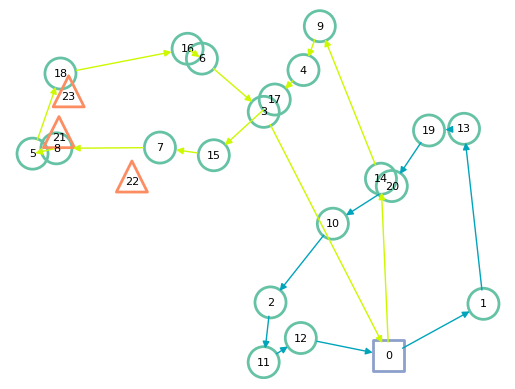

In [97]:
env.render(td_init[0], actions[0])

Note: Some errors may appear below due to precision issues in the MILP solver, which uses a tolerance of 10e-6

In [96]:
check_actions_with_mask(td_init, env, actions, display_errors=True)

Checked 100 results
All results are valid.
